# Block 5 Exercise 2: Predicting the fare of taxi rides
Using the NY Taxi data set (see Use Case Block I) and the use case from the lecture...

In [1]:
import pandas as pd
import numpy as np
import folium


In [2]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


In [3]:
# we load the data we have saved after wrangling and pre-processing in block I
X=pd.read_csv(path+'/DATA/train_cleaned.csv')
drop_columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']
X=X.drop(drop_columns,axis=1)
X=pd.get_dummies(X)# one hot coding
#generate labels
y=X['fare_amount']
X=X.drop(['fare_amount'],axis=1)

In [4]:
# a quick look at the data
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,...,pickup_borough_manhattan,pickup_borough_others,pickup_borough_queens,pickup_borough_staten_island,dropoff_borough_bronx,dropoff_borough_brooklyn,dropoff_borough_manhattan,dropoff_borough_others,dropoff_borough_queens,dropoff_borough_staten_island
0,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,...,0,0,1,0,0,0,0,0,1,0
1,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,...,1,0,0,0,0,0,1,0,0,0
2,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,...,1,0,0,0,0,0,1,0,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,...,1,0,0,0,0,0,1,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,...,1,0,0,0,0,0,1,0,0,0


In [5]:
y.head()

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64

### E 2.1 Split data into train and test data
* use data from 2009-2014 for training and 2015 for evaluation


In [14]:
X_train=X[X['pickup_year']<2015]
y_train=y[X['pickup_year']<2015]
X_test=X[X['pickup_year']==2015]
y_test=y[X['pickup_year']==2015]

In [22]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(372110, 31) (372110,) (27890, 31) (27890,)


In [38]:
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=np.array(X_train)
X_test=np.array(X_test)

In [41]:
y_train

array([ 4.5, 16.9,  5.7, ...,  3. , 11.5,  7.3])

### E 2.2 Train a Random Forest Regression Model
* train model using [RF regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* optimize the model parameters (#trees, depth, vars per split, ...) and evaluate the [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) on train and test data
* Analyze the model error: are there typical settings where the model fails?

In [43]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_jobs=4, n_estimators=10)

In [44]:
%%time
rf.fit(X_train,y_train)

CPU times: user 52.2 s, sys: 157 ms, total: 52.3 s
Wall time: 16 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=4, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,rf.predict(X_test))

23.378506651918254

MSE is quite high - but this is an average error, so look at the error distribution

In [47]:
dif = np.abs(y_test - rf.predict(X_test))

In [48]:
import matplotlib.pyplot as plt

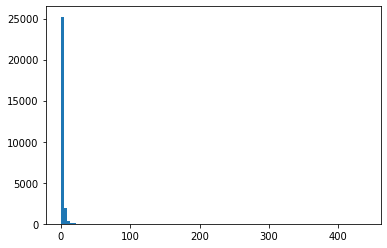

In [51]:
t=plt.hist(dif,bins=100)

looks like we have some heavy outliers! Look at the better samples:

In [56]:
dif_20=dif[dif<20]

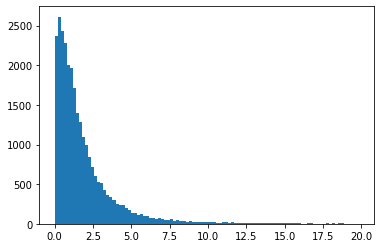

In [57]:
t=plt.hist(dif_20,bins=100)

Still, most predictions are less then 2$ off ...

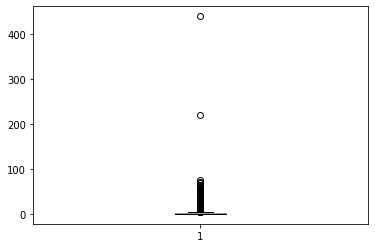

In [93]:
t=plt.boxplot(dif)

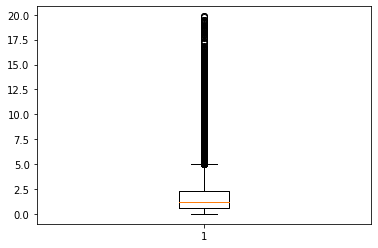

In [94]:
t=plt.boxplot(dif_20)

In [61]:
np.median(dif)

1.2000000000000002

In [64]:
#get all with an error > 10 
bad_10 = X_test[dif>10]
bad_100 = X_test[dif>100]

In [63]:
np.shape(bad_10) #how many bas predictions do we have

(538, 31)

In [65]:
np.shape(bad_100)

(2, 31)

In [68]:
#focus on bad_10


array([-7.38730545e+01,  4.07740860e+01, -7.39827271e+01,  4.07714958e+01,
        1.00000000e+00,  1.90000000e+01,  1.20000000e+01,  4.00000000e+00,
        3.00000000e+00,  2.01500000e+03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        5.74137694e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [79]:
#draw map: green: start, red: end
error_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
for i in range(np.shape(bad_10)[0]):
    folium.CircleMarker([bad_10[i,1], bad_10[i,0]], radius=3,                
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(error_map)
    folium.CircleMarker([bad_10[i,3], bad_10[i,2]], radius=3,                
                        color="red", 
                        fill_opacity=0.9
                       ).add_to(error_map)
    folium.PolyLine([ [bad_10[i,1],bad_10[i,0]] , [bad_10[i,3],bad_10[i,2]]  ], color="black", weight=2.5, opacity=1).add_to(error_map)

In [80]:
error_map

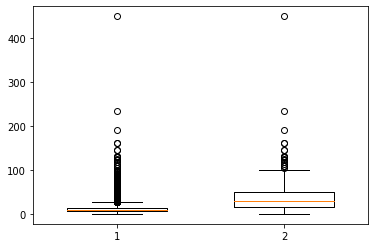

In [90]:
#look at the fare
t=plt.boxplot(y_test,positions = [1], widths = 0.6)
t=plt.boxplot(y_test[dif>10],positions = [2], widths = 0.6)

In [97]:
#compute correlation between features and error
np.corrcoef(X_test, dif, rowvar=False)[-1, :-1]

array([ 0.15304966, -0.06678352,  0.1156469 , -0.03182656,  0.00362742,
       -0.00509591, -0.00698048,  0.00660045,  0.0090191 ,         nan,
        0.10410583,  0.04181249,  0.05987274,  0.05863375,  0.09975827,
        0.07027108,  0.15336846, -0.021474  , -0.03073417,  0.01954649,
        0.01698397, -0.17290481,  0.19661253,  0.15682099,         nan,
        0.03441649,  0.03676528, -0.15841587,  0.19503181,  0.1088292 ,
        0.02980575])

In [98]:
#see what feature this was...
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,...,pickup_borough_manhattan,pickup_borough_others,pickup_borough_queens,pickup_borough_staten_island,dropoff_borough_bronx,dropoff_borough_brooklyn,dropoff_borough_manhattan,dropoff_borough_others,dropoff_borough_queens,dropoff_borough_staten_island
0,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,...,0,0,1,0,0,0,0,0,1,0
1,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,...,1,0,0,0,0,0,1,0,0,0
2,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,...,1,0,0,0,0,0,1,0,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,...,1,0,0,0,0,0,1,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,...,1,0,0,0,0,0,1,0,0,0
